Water Network: d1_Sample_input_cycle_twoloop 

Objective:  433926.19753755606
solve_result:  solved
Generate the acyclic network using ipopt solution
cost: 433926.19757699734
Objective:  433926.19757699734
solve_result:  solved

Presolve the model for fixing the arc direction
Is node 1 in cycle? False
Fix the arc (1, 2)
Is node 2 in cycle? True
Fix the arc (2, 4)
Fix the arc (2, 3)
fixed arc direction: [(1, 2), (2, 4), (2, 3)] 



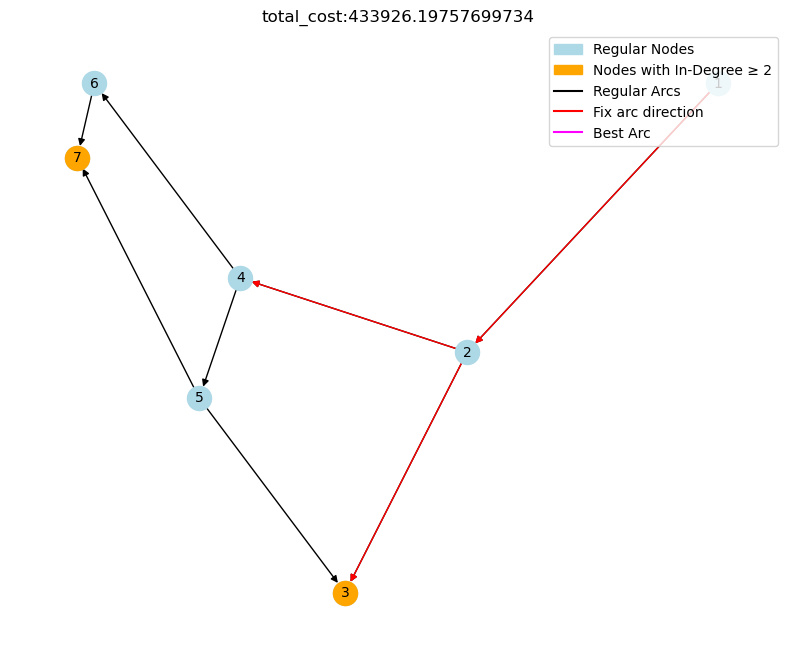

Iteration : 1
Acyclic network arcs direction:  [(1, 2), (2, 4), (2, 3), (4, 5), (4, 6), (5, 3), (5, 7), (6, 7)]
Fixed arc set: [(1, 2), (2, 4), (2, 3)]
Node: 3 in_degree: 2
Arc (5, 3) Acyclic: True Best optimal:  433926.19757699734 New optimal:  429525.9573765767 Solve_result:  solved Improved: Yes


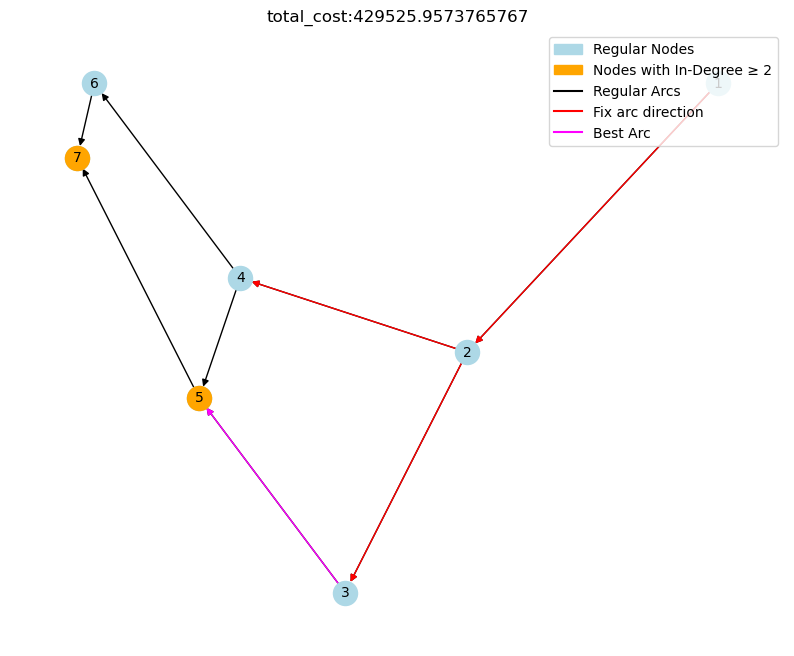

 
Node: 7 in_degree: 2
Arc (5, 7) Acyclic: True Best optimal:  429525.9573765767 New optimal:  429525.9573924634 Solve_result:  solved Improved: No
Arc (6, 7) Acyclic: True Best optimal:  429525.9573765767 New optimal:  478891.6848785846 Solve_result:  solved Improved: No
 
Iteration : 2
Acyclic network arcs direction:  [(1, 2), (2, 4), (2, 3), (3, 5), (4, 5), (4, 6), (5, 7), (6, 7)]
Fixed arc set: [(1, 2), (2, 4), (2, 3)]
Node: 5 in_degree: 2
Arc (3, 5) Acyclic: True Best optimal:  429525.9573765767 New optimal:  429525.9563108152 Solve_result:  solved Improved: Yes


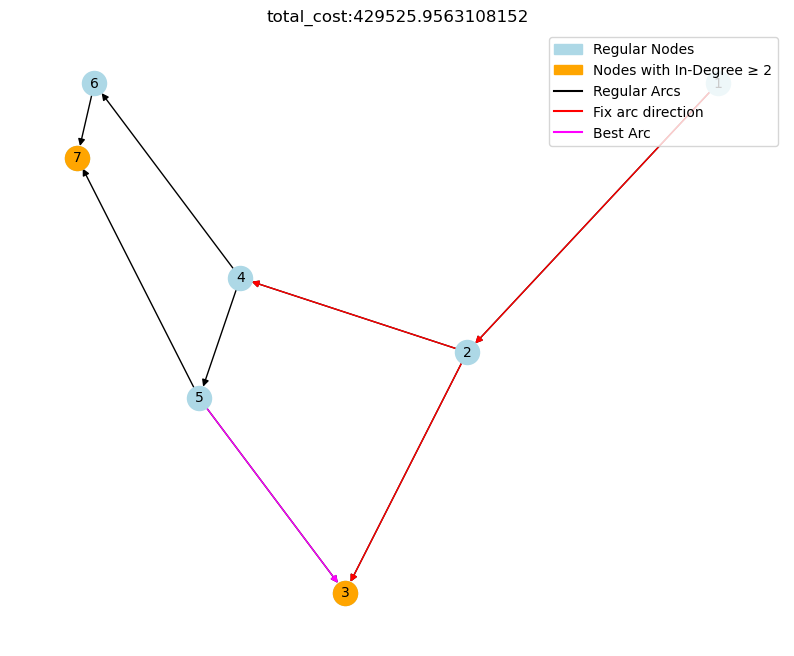

Arc (4, 5) Acyclic: True Best optimal:  429525.9563108152 New optimal:  457695.3397581702 Solve_result:  solved Improved: No
 
Node: 7 in_degree: 2
Arc (5, 7) Acyclic: True Best optimal:  429525.9563108152 New optimal:  403604.9406456724 Solve_result:  solved Improved: Yes


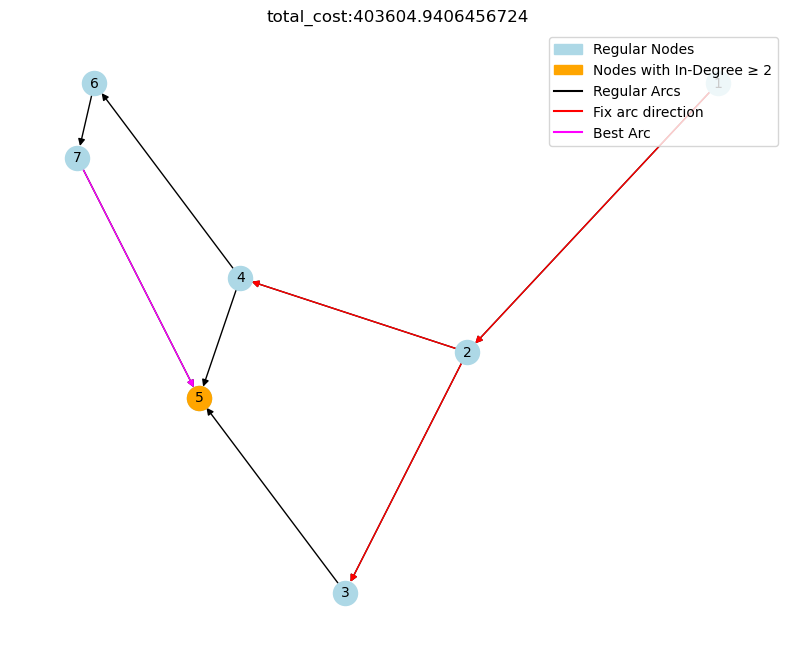

Arc (6, 7) Acyclic: True Best optimal:  403604.9406456724 New optimal:  468421.46472266124 Solve_result:  solved Improved: No
 
Iteration : 3
Acyclic network arcs direction:  [(1, 2), (2, 4), (2, 3), (3, 5), (4, 6), (4, 5), (6, 7), (7, 5)]
Fixed arc set: [(1, 2), (2, 4), (2, 3)]
Node: 5 in_degree: 3
Arc (3, 5) Acyclic: True Best optimal:  403604.9406456724 New optimal:  429525.9573924634 Solve_result:  solved Improved: No
Arc (4, 5) Acyclic: False
Arc (7, 5) Acyclic: True Best optimal:  403604.9406456724 New optimal:  429525.9573765767 Solve_result:  solved Improved: No
 
*********************************************************Final best results***************************************************************
Final best objective: 403604.9406456724
Solver_time: 1.3880029999999999
Heuristic elapsed time: 2.424652576446533


In [141]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()


    def plot_graph(self, super_source_out_arc=None, best_arc=None, current_cost = None, iteration = 1):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        # new_positions = {
        #     1: (0.5, -1.5),
        #     2: (0, -1),
        #     3: (0, 0),
        #     4: (1, 0),
        #     5: (2, 0),
        #     6: (3, 0),
        #     7: (3, 1),
        #     8: (3, 2),
        #     9: (3, 3),
        #     10: (2.25, 3),
        #     11: (2.25, 3.75),
        #     12: (2.25, 4.5),
        #     13: (1.5, 4.5),
        #     14: (1.5, 3),
        #     15: (0.75, 3),
        #     16: (0, 3),
        #     17: (0, 2.25),
        #     18: (0, 1.5),
        #     19: (0, 0.75),
        #     20: (-1, 0),
        #     21: (-1, -0.75),
        #     22: (-1, -1.5),
        #     23: (-2, 0),
        #     24: (-2, 1.5),
        #     25: (-2, 3),
        #     26: (-1.33, 3),
        #     27: (-0.66, 3),
        #     28: (-2.66, 0),
        #     29: (-3.32, 0),
        #     30: (-3.32, 1.5),
        #     31: (-3.32, 3),
        #     32: (-2.66, 3)
        # }
        new_positions = {
            1: (0, 0),
            2: (-1, 0),
            3: (-2, 0),
            4: (-1, -1),
            5: (-2, -1),
            6: (-1, -2),
            7: (-2, -2)
        }
        # # Update node positions
        # pos = new_positions
        pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(10, 8))
        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1, label = 'Best arc')
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line, best_edge_line], loc='upper right')

        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show() 
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
                
    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True

    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        self.load_model()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')
        
    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        for node in indegree_2_or_more:
            print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for u,v in list(self.network_graph.in_edges(node)):
                if (u,v) not in super_source_out_arc and (u,v) not in BEST_ARC:
                    self.network_graph.remove_edge(u,v)
                    self.network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(self.network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    if acy_check and in_arc_check:
                        # l_sol, q_sol, h_sol = self.generate_initial_points()
                        self.load_model()
                        # self.update_initial_points(l_sol, q_sol, h_sol)
                        self.update_model()
                        self.solve()
                        # print("cost:", self.total_cost)   
                        # self.display_results()
                        if self.solve_result == "solved":
                            if self.total_cost < current_cost:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", current_cost, "New optimal: ", self.total_cost, "Solve_result: ", self.solve_result, "Improved: Yes")
                                current_cost = self.total_cost
                                improved = True
                                best_acyclic_flow = self.network_graph.copy()
                                best_arc = (v,u)
                                self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
                                l = self.ampl.getVariable('l').getValues().to_list()
                                q = self.ampl.getVariable('q').getValues().to_list()
                                h = self.ampl.getVariable('h').getValues().to_list()
                                
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                                # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
                            else:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", current_cost, "New optimal: ", self.total_cost, "Solve_result: ", self.solve_result, "Improved: No")
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                        else:
                            print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check," Best optimal: ", current_cost, "New optimal: ", self.total_cost, "Solve_result: ", self.solve_result)
                            self.network_graph.remove_edge(v, u)
                            self.network_graph.add_edge(u, v)                         
                    else:
                        print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)                      
            print(" ")
        return best_acyclic_flow, improved, current_cost, l, q, h, best_arc

    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_list()
            q = self.ampl.getVariable('q').getValues().to_list()
            h = self.ampl.getVariable('h').getValues().to_list()
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        self.plot_graph(super_source_out_arc, best_arc, current_cost, 0)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        
        while improved:
            print("Iteration :",iteration)
            best_acyclic_flow, improved, current_cost, l, q, h, best_arc = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
        
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr   
    
    def solve(self):
        with self.suppress_output():
            """Solve the optimization problem."""
            self.ampl.option["solver"] = "ipopt"
            self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.0001 bound_frac = 0.0001")
            self.ampl.option["presolve_eps"] = " 8.53e-15"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            self.ampl.solve()
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
            # print("Objective:", self.total_cost)
            # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
    
    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time()
        self.load_model()
        self.solve()
        cost = self.total_cost
        # self.display_results()
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()

        self.load_model()
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.update_model()
        self.solve()
        cost = self.total_cost
        print("cost:", self.total_cost)                            
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        if self.total_cost > cost:
            self.total_cost = cost
        
        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time
        
        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)
        
if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]
    # Select the data number here (0 to 18)
    data_number = 0
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()

Water Network: d1_Sample_input_cycle_twoloop 

Objective:  0.0
solve_result:  failure
Generate the acyclic network using ipopt solution
cost: 0.0
Objective:  0.0
solve_result:  failure

Presolve the model for fixing the arc direction
Is node 1 in cycle? False
Fix the arc (1, 2)
Is node 2 in cycle? True
Fix the arc (2, 4)
Fix the arc (2, 3)
fixed arc direction: [(1, 2), (2, 4), (2, 3)] 



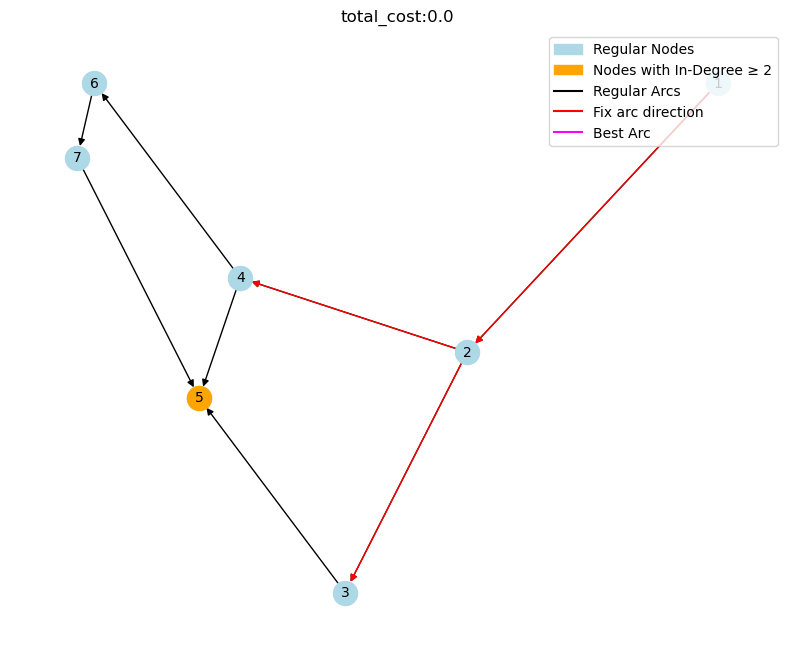

Iteration : 1
Acyclic network arcs direction:  [(1, 2), (2, 4), (2, 3), (3, 5), (4, 5), (4, 6), (6, 7), (7, 5)]
Fixed arc set: [(1, 2), (2, 4), (2, 3)]
Node: 5 in_degree: 3
Arc (3, 5) Acyclic: True  Best optimal:  1000000000000000.0 New optimal:  0.0 Solve_result:  failure
Arc (4, 5) Acyclic: False
Arc (7, 5) Acyclic: True  Best optimal:  1000000000000000.0 New optimal:  0.0 Solve_result:  failure
 
*********************************************************Final best results***************************************************************
Final best objective: 1000000000000000.0
Solver_time: 0.040747000000000026
Heuristic elapsed time: 0.305325984954834


In [198]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore")

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    def display_best_results(self,ampl):
        ampl.eval("display {(i,j) in arcs}: q[i,j];")
        ampl.eval("display l;")
        ampl.eval("display h;")
        ampl.eval("display solve_result;")
        total_cost = ampl.get_objective("total_cost").value()
        print("Objective:", total_cost)
    
    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()


    def plot_graph(self, super_source_out_arc=None, best_arc=None, current_cost = None, iteration = 1):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        # new_positions = {
        #     1: (0.5, -1.5),
        #     2: (0, -1),
        #     3: (0, 0),
        #     4: (1, 0),
        #     5: (2, 0),
        #     6: (3, 0),
        #     7: (3, 1),
        #     8: (3, 2),
        #     9: (3, 3),
        #     10: (2.25, 3),
        #     11: (2.25, 3.75),
        #     12: (2.25, 4.5),
        #     13: (1.5, 4.5),
        #     14: (1.5, 3),
        #     15: (0.75, 3),
        #     16: (0, 3),
        #     17: (0, 2.25),
        #     18: (0, 1.5),
        #     19: (0, 0.75),
        #     20: (-1, 0),
        #     21: (-1, -0.75),
        #     22: (-1, -1.5),
        #     23: (-2, 0),
        #     24: (-2, 1.5),
        #     25: (-2, 3),
        #     26: (-1.33, 3),
        #     27: (-0.66, 3),
        #     28: (-2.66, 0),
        #     29: (-3.32, 0),
        #     30: (-3.32, 1.5),
        #     31: (-3.32, 3),
        #     32: (-2.66, 3)
        # }
        new_positions = {
            1: (0, 0),
            2: (-1, 0),
            3: (-2, 0),
            4: (-1, -1),
            5: (-2, -1),
            6: (-1, -2),
            7: (-2, -2)
        }
        # # Update node positions
        # pos = new_positions
        pos = nx.spectral_layout(self.network_graph)

        plt.figure(figsize=(10, 8))
        # Draw nodes with default color (lightblue)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=300, label='Regular Nodes')

        # Highlight nodes with in-degree >= 2
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=300, label='Nodes with In-Degree ≥ 2')

        # Draw node labels
        nx.draw_networkx_labels(self.network_graph, pos, font_size=10)

        # Draw edges
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black', label='Regular Arcs')

        # Highlight super-source edges in red
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1, label='Fix arc direction')

        # Highlight the best arc in magenta
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1, label = 'Best arc')
        
        # Create legend
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line, best_edge_line], loc='upper right')

        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show() 
        
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self):
        print("Generate the acyclic network using ipopt solution")
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        
        q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in edges_list:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)

    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  

    def update_model_lp(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q_lp[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];") 
                
    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True

    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        self.load_model()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        print("fixed arc direction:",set_, "\n") 
        return set_

    def generate_initial_points(self):
        # self.ampl = AMPL()
        self.ampl.reset()
        self.ampl.read("/home/nitishdumoliya/waterNetwork/model/mccormic_rel.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        self.update_model()
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l").get_values().to_dict()
        q_solution = self.ampl.get_variable("q").get_values().to_dict()
        h_solution = self.ampl.get_variable("h").get_values().to_dict()
        
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
#         self.ampl.reset()
#         self.ampl.read("/home/nitishdumoliya/waterNetwork/model/potentialBasedFlow/content_model.mod")
#         self.ampl.read_data(self.data_file)
#         self.ampl.option['solver'] = 'ipopt'
#         self.ampl.option['presolve_eps'] = '1.19e-08'
#         self.update_model()
        
#         for (i, j, k) in l_solution.keys():
#             if l_solution[i, j, k] >= 1:
#                 self.ampl.eval(f"s.t. fix_length_{i}_{j}_{k}: l[{i},{j},{k}]={l_solution[i, j, k]};")
        
#         self.ampl.solve()
#         # l_solution = self.ampl.get_variable("l").get_values().to_dict()
#         q_solution = self.ampl.get_variable("q").get_values().to_dict()
#         # h_solution = self.ampl.get_variable("h").get_values().to_dict()
#         print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        self.ampl.reset()
        self.ampl.read("../lpNlp/lp_model.mod")
        self.ampl.read_data(self.data_file)
        self.ampl.option['solver'] = 'cplexamp'
        # self.update_model_lp()   
        
        for (i, j), value in q_solution.items():
            self.ampl.param['q_lp'][i, j] = value
        
        self.ampl.solve()
        l_solution = self.ampl.get_variable("l_lp").get_values().to_dict()
        h_solution = self.ampl.get_variable("h_lp").get_values().to_dict()
        print("total_cost:", self.ampl.get_objective("total_cost").value())
        
        return l_solution, q_solution, h_solution
        
    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        for (i, j), val in q_solution.items():
            if (i,j) in edge_list_network:
                self.ampl.eval(f"let q[{i},{j}]:= {val};")
            else:
                self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')


    def iterate_arc(self, iteration, best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc):
        improved = False
        self.network_graph = best_acyclic_flow.copy()
        print("Acyclic network arcs direction: ",self.network_graph.edges())
        # self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
        print("Fixed arc set:",super_source_out_arc)
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
 
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        for node in indegree_2_or_more:
            print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for u,v in list(self.network_graph.in_edges(node)):
                if (u,v) not in super_source_out_arc and (u,v) not in BEST_ARC:
                    self.network_graph.remove_edge(u,v)
                    self.network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(self.network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    if acy_check and in_arc_check:
                        #l_sol, q_sol, h_sol = self.generate_initial_points()
                        self.load_model()
                        self.update_initial_points(l_sol, q_sol, h_sol)
                        self.update_model()
                        self.solve()
                        # print("cost:", self.total_cost)   
                        # self.display_results()
                        if self.solve_result == "solved":
                            if self.total_cost < current_cost:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", current_cost, "New optimal: ", self.total_cost, "Solve_result: ", self.solve_result, "Improved: Yes")
                                current_cost = self.total_cost
                                improved = True
                                best_acyclic_flow = self.network_graph.copy()
                                best_arc = (v,u)
                                self.plot_graph(super_source_out_arc, best_arc, current_cost, iteration)
                                l = self.ampl.getVariable('l').getValues().to_dict()
                                q = self.ampl.getVariable('q').getValues().to_dict()
                                h = self.ampl.getVariable('h').getValues().to_dict()
                                
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                                # return best_acyclic_flow, improved, current_cost, l, q, h, best_arc
                            else:
                                print("Arc", (u,v),"Acyclic:", acy_check and in_arc_check, "Best optimal: ", current_cost, "New optimal: ", self.total_cost, "Solve_result: ", self.solve_result, "Improved: No")
                                self.network_graph.remove_edge(v, u)
                                self.network_graph.add_edge(u, v)  
                        else:
                            print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check," Best optimal: ", current_cost, "New optimal: ", self.total_cost, "Solve_result: ", self.solve_result)
                            self.network_graph.remove_edge(v, u)
                            self.network_graph.add_edge(u, v)                         
                    else:
                        print("Arc", (u,v),"Acyclic:",acy_check and in_arc_check)
                        self.network_graph.remove_edge(v, u)
                        self.network_graph.add_edge(u, v)                      
            print(" ")
        return best_acyclic_flow, improved, current_cost, l, q, h, best_arc

    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        best_acyclic_flow = self.network_graph.copy()
        
        if self.solve_result == "solved":
            current_cost = self.total_cost  
            l = self.ampl.getVariable('l').getValues().to_dict()
            q = self.ampl.getVariable('q').getValues().to_dict()
            h = self.ampl.getVariable('h').getValues().to_dict()
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            l = None
            q = None
            h = None
        
        # acyclicity_time = 0
        iteration = 1
        best_arc = None
        super_source_out_arc = self.fix_arc_set()
        self.plot_graph(super_source_out_arc, best_arc, current_cost, 0)
        # super_source_out_arc.append(best_arc)
        # print("super_source_out_arc:",super_source_out_arc)
        # super_source_out_arc = self.fix_arc(self.data_number)
        
        while improved:
            print("Iteration :",iteration)
            best_acyclic_flow, improved, current_cost, l, q, h, best_arc = self.iterate_arc(iteration,best_acyclic_flow, improved, current_cost, l, q, h, best_arc, super_source_out_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        print("*********************************************************Final best results***************************************************************")
        print(f"Final best objective: {current_cost}")
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()

    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr

    def solve(self):
        with self.suppress_output():
            """Solve the optimization problem."""
            self.ampl.option["solver"] = "ipopt"
            self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes least_square_init_duals = no")
            self.ampl.option["presolve_eps"] = "8.53e-15"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            self.ampl.solve()
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
            # print("Objective:", self.total_cost)
            # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
    
    def run(self):
        """Main method to run the optimization process."""
        start_time = time.time()
        self.load_model()
        self.solve()
        cost = self.total_cost
        # self.display_results()
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        l_sol = self.ampl.getVariable('l').getValues().to_dict()
        q_sol = self.ampl.getVariable('q').getValues().to_dict()
        h_sol = self.ampl.getVariable('h').getValues().to_dict()
        # print("solve_result: ",self.solve_result)
        self.generate_random_acyclic_from_solution()
        # print("Acyclic network:",self.network_graph.edges(), "\n")
        # self.generate_random_acyclic_graph()
        # l_sol, q_sol, h_sol = self.generate_initial_points()

        self.load_model()
        self.update_initial_points(l_sol, q_sol, h_sol)
        self.update_model()
        self.solve()
        cost = self.total_cost
        print("cost:", self.total_cost)                            
        # if self.solve_result == "solved":
        #     l_init, q_init, h_init = self.generate_bounding_box_points(num_samples=20)  # Generate 2 feasible points
        #     self.set_initial_point(l_init, q_init, h_init)
        #     # l_init, q_init, h_init = self.orthogonal_perturbation(perturbation_factor=0.02)
        #     # self.set_initial_point(l_init, q_init, h_init)
        #     self.solve()
        #     print("perturbed cost:", self.total_cost)
        # Get the solver results
        print("Objective: ",self.total_cost)
        print("solve_result: ",self.solve_result)
        if self.total_cost > cost:
            self.total_cost = cost

        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - start_time

        print("Solver_time:",self.solver_time)
        print("Heuristic elapsed time:", elapsed_time)

if __name__ == "__main__":
    data_list = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    # Select the data number here (0 to 18)
    data_number = 0
    input_data_file = f"/home/nitishdumoliya/waterNetwork/data/{data_list[data_number]}.dat"
    print("Water Network:", data_list[data_number],"\n")
    optimizer = WaterNetworkOptimizer("../m1Basic.mod", input_data_file, data_number)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[3], sys.argv[2])
    optimizer.run()